In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf
import yahoofinancials
import seaborn as sns
import datetime
from datetime import date
import matplotlib.pyplot as plt

import math
from datetime import date

In [2]:
N = norm.cdf

In [3]:
today = str(date.today())
print(today)

2022-09-23


In [4]:
yf.pdr_override() 
df = pdr.get_data_yahoo("ETH-USD", start="2022-01-01", end=today)

df['Date'] = df.index
df['Return'] = 100 * (df['Close'].pct_change())

daily_volatility = df['Return'].std()
monthly_volatility = math.sqrt(30) * daily_volatility

period_volatility = (math.sqrt(len(df.index)) * daily_volatility) / 100

print("volatility over period:", period_volatility)

[*********************100%***********************]  1 of 1 completed
volatility over period: 0.7705407498785526


In [5]:
df

,Open,High,Low,Close,Adj Close,Volume,Date,Return
Date,,,,,,,,
2021-12-31,3713.430176,3807.288818,3636.869873,3682.632812,3682.632812,14157285268,2021-12-31,NaN
2022-01-01,3683.047119,3769.917969,3682.286621,3769.697021,3769.697021,9776191466,2022-01-01,2.364184
2022-01-02,3769.298340,3836.161865,3727.357422,3829.564941,3829.564941,9881471548,2022-01-02,1.588136
2022-01-03,3829.535645,3836.198730,3698.047607,3761.380371,3761.380371,12080777893,2022-01-03,-1.780478
2022-01-04,3761.361572,3876.785156,3723.349854,3794.056641,3794.056641,14030925983,2022-01-04,0.868731
...,...,...,...,...,...,...,...,...
2022-09-18,1469.705444,1469.705444,1331.494751,1335.329102,1335.329102,15762284723,2022-09-18,-9.145321
2022-09-19,1335.270752,1388.272217,1287.420898,1377.541382,1377.541382,18712714223,2022-09-19,3.161189
2022-09-20,1377.619019,1381.965698,1319.201416,1324.388184,1324.388184,14722317220,2022-09-20,-3.858555


In [6]:
def D1(S,K,T,r,sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return d1

def delta_BS_CALL(S,K,T,r,sigma):
    d1 = D1(S,K,T,r,sigma)
    delta = N(d1)
    return delta

def expiration(now):
    d0 = pd.Timestamp(df["Date"].iloc[1], tz=None)
    d1 = pd.Timestamp(now, tz=None)

    d = d1 - d0
    delta = d.days / 365
    
    return delta
    
expiration(df["Date"].iloc[265])

0.7232876712328767

In [7]:
K = 1000 # strike
r = 0.1 # risk free rate
sigma = period_volatility

In [8]:
# Time to expiration in years
df['T'] = df.apply(lambda x: expiration(x['Date']), axis=1)

In [9]:
# Delta
df['Delta'] = df.apply(lambda x: delta_BS_CALL(x['Close'], K, x['T'], r, 0.8), axis=1)

/tmp/ipykernel_222081/1715699428.py:2: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
/tmp/ipykernel_222081/1715699428.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))


<AxesSubplot:xlabel='Date'>

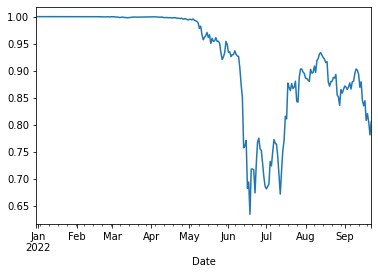

In [10]:
df["Delta"].plot()

<AxesSubplot:xlabel='Date'>

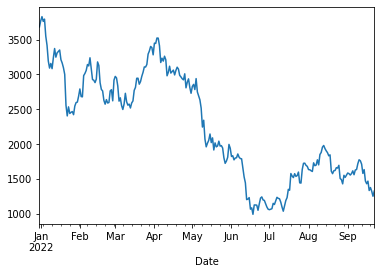

In [11]:
df["Close"].plot()

In [12]:
df

,Open,High,Low,Close,Adj Close,Volume,Date,Return,T,Delta
Date,,,,,,,,,,
2021-12-31,3713.430176,3807.288818,3636.869873,3682.632812,3682.632812,14157285268,2021-12-31,NaN,-0.002740,NaN
2022-01-01,3683.047119,3769.917969,3682.286621,3769.697021,3769.697021,9776191466,2022-01-01,2.364184,0.000000,1.000000
2022-01-02,3769.298340,3836.161865,3727.357422,3829.564941,3829.564941,9881471548,2022-01-02,1.588136,0.002740,1.000000
2022-01-03,3829.535645,3836.198730,3698.047607,3761.380371,3761.380371,12080777893,2022-01-03,-1.780478,0.005479,1.000000
2022-01-04,3761.361572,3876.785156,3723.349854,3794.056641,3794.056641,14030925983,2022-01-04,0.868731,0.008219,1.000000
...,...,...,...,...,...,...,...,...,...,...
2022-09-18,1469.705444,1469.705444,1331.494751,1335.329102,1335.329102,15762284723,2022-09-18,-9.145321,0.712329,0.808228
2022-09-19,1335.270752,1388.272217,1287.420898,1377.541382,1377.541382,18712714223,2022-09-19,3.161189,0.715068,0.820539
2022-09-20,1377.619019,1381.965698,1319.201416,1324.388184,1324.388184,14722317220,2022-09-20,-3.858555,0.717808,0.804915


In [13]:
# not finished...

def cashBalance(S, delta0, delta1, cash):
    cash1 = cash - ((delta1 - delta0) * S)    
    return cash1

def underlyingBalance(delta, liquidity):
    return 0
    


In [14]:
def portfolioValue():
    return 0